In [2]:
# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import sys
from datetime import datetime
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import cv2
# Sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
# TorchVision
from torchvision import models, transforms, datasets
from torchvision.utils import make_grid
device = torch.device('cuda')
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
seed_everything(seed)

In [4]:
df_train = pd.read_csv('/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/trainset/trainset_true.csv')
df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x=='F'))
df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
df_train['AGE'] = df_train['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))
df_train.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P26,1,0,11/3/1933,11.2,87
1,P183,1,0,5/15/1942,12.8,78
2,P89,1,0,6/19/1935,9.6,85
3,P123,1,0,1/27/1931,122.6,89
4,P61,1,1,3/5/1931,11.6,89


In [6]:
df_test = pd.read_csv('/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/testset/testset_data.csv')
df_test['GENDER'] = df_test.GENDER.apply(lambda x: int(x=='F'))
df_test['DOB'] = df_test['DOB'].apply(lambda x: x.replace("-", "/"))
df_test['AGE'] = df_test['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))
df_test.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P71,-1,0,1/17/1946,5.76,74
1,P16,-1,0,3/5/1940,32.00,80
2,P114,-1,0,6/16/1929,4.60,91
3,P170,-1,0,11/3/1933,4.80,87
4,P98,-1,1,5/14/1970,6.24,50


In [7]:
import torch
import cv2
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class LymphBags(torch.utils.data.Dataset):
    def __init__(self, bags_dir, df, indices, mode='train', transforms=None, max_seq_len=None):
        assert mode in ['train', 'test'], "mode must belong to ['train', 'test']"
        self.transforms = transforms
        self.mode = mode
        self.df = df
        self.dir = bags_dir
        self.bags = list(filter(lambda x: x[0] == 'P', os.listdir(bags_dir)))
        self.bags = [self.bags[i] for i in indices]
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, index):
        if self.mode == 'train':
            bags = os.path.join(self.dir, self.bags[index])
            images = []
            for bag in os.listdir(bags):
                img = cv2.imread(os.path.join(bags, bag))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(img)  # Convert the NumPy array to a PIL Image object
                if self.transforms:
                    img = self.transforms(img)
                images.append(img)

            # Convert the list of image tensors to a single tensor
            images = torch.stack(images)

            # Pad the images if necessary
            if len(images) < self.max_seq_len:
                padding = torch.zeros((self.max_seq_len - len(images), 3, 224, 224))
                images = torch.cat((images, padding), dim=0)

            idx_ = self.df[self.df['ID'] == self.bags[index]].index[0]
            gender = torch.as_tensor([self.df.iloc[idx_, 2]])
            count = torch.as_tensor([self.df.iloc[idx_, 4]])
            age = torch.as_tensor([self.df.iloc[idx_, -1]])
            label = self.df.iloc[idx_, 1]

            return images, gender, count, age, label

        else:
            bags = os.path.join(self.dir, self.bags[index])
            idx_ = self.df[self.df['ID'] == self.bags[index]].index[0]
            images = []
            for bag in os.listdir(bags):
                img = cv2.imread(os.path.join(bags, bag))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(img)  # Convert the NumPy array to a PIL Image object
                if self.transforms:
                    img = self.transforms(img)
                images.append(img)

            # Convert the list of image tensors to a single tensor
            images = torch.stack(images)

            # Pad the images if necessary
            if len(images) < self.max_seq_len:
                padding = torch.zeros((self.max_seq_len - len(images), 3, 224, 224))
                images = torch.cat((images, padding), dim=0)

            gender = torch.as_tensor([self.df.iloc[idx_, 2]])
            count = torch.as_tensor([self.df.iloc[idx_, 4]])
            age = torch.as_tensor([self.df.iloc[idx_, -1]])

            return images, gender, count, age, idx_



In [8]:
def train_val_dataset(df, bags_dir, train_transforms=transforms, val_transforms=transforms, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split, stratify = df.LABEL.values)
    train_set = LymphBags(bags_dir, df, indices = train_idx, transforms=train_transforms,max_seq_len=198)
    val_set = LymphBags(bags_dir, df, indices = val_idx, transforms=val_transforms,max_seq_len=198)
    return train_set, val_set

In [9]:
train_dir = '/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/trainset'
test_dir = '/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/testset'

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset, valset = train_val_dataset(df_train, train_dir, train_transforms=transforms_train, val_transforms=transforms_val, val_split=0.25)

train_loader = DataLoader(trainset,batch_size=2, shuffle=True, pin_memory=False)
val_loader = DataLoader(valset,batch_size=2, shuffle=True, pin_memory=False)

In [10]:
# Create a list of indices covering the entire range of the test dataset
test_indices = list(range(len(df_test)))

# Create the test dataset
testset = LymphBags(test_dir, df_test, indices=test_indices, transforms=transforms_val,max_seq_len=198)

# Create the test loader
test_loader = DataLoader(testset, batch_size=1, shuffle=False, pin_memory=True)


In [12]:
for images, gender, count, age, label in test_loader:
    print('Training data:')
    print('Images shape:', images.size())
    print('Gender shape:', gender.size())
    print('Count shape:', count.size())
    print('Age shape:', age.size())
    print('Label shape:', label.size())
    break  # Exit the loop after printing the size of the first batch

Training data:
Images shape: torch.Size([1, 198, 3, 224, 224])
Gender shape: torch.Size([1, 1])
Count shape: torch.Size([1, 1])
Age shape: torch.Size([1, 1])
Label shape: torch.Size([1])


In [12]:
torch.cuda.empty_cache()

In [13]:
import torch
from torch import nn
from torchvision.models import resnet34

class AttentionModule(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Tanh(),
            nn.Linear(out_features, 1)
        )

    def forward(self, x):
        attention_weights = torch.softmax(self.attention(x), dim=1)
        return (attention_weights * x).sum(dim=1)

class MILModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = resnet34(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the final FC layer
        self.attention = AttentionModule(512, 256)  # Adjust these dimensions as needed
        self.classifier = nn.Sequential(
            nn.Linear(512 + 3, 256),  # 2048 from attention, 3 from additional features
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, images, additional_features):
        batch_size, num_images, channels, height, width = images.shape
        reshaped_images = images.view(-1, channels, height, width)  # Reshape to collapse batch_size and num_images

        reshaped_features = self.feature_extractor(reshaped_images)
        image_features = reshaped_features.view(batch_size, num_images, -1)  # Reshape to separate batch_size and num_images

        image_representation = self.attention(image_features)
        image_representation = image_representation.float()
        additional_features = additional_features.float()
        final_representation = torch.cat([image_representation, additional_features], dim=1)
        return self.classifier(final_representation)



In [14]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
from torch.optim.lr_scheduler import CyclicLR


def balanced_accuracy(outputs, labels):
    outputs = outputs.cpu().detach().numpy()
    labels = labels.cpu().numpy()
    return balanced_accuracy_score(labels, (outputs >= 0.5).astype(int))

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = MILModel().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=2000, cycle_momentum=False)


train_losses, val_losses = [], []
train_balanced_accs, val_balanced_accs = [], []
# Set the number of epochs
num_epochs = 40
best_val_balanced_acc = 0.0

# Training and Validation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_balanced_acc = 0.0

    for images, gender, count, age, labels in tqdm(train_loader, desc="Training"):
        # Move the tensors to the device
        images = images.to(device)
        gender = gender.to(device)
        count = count.to(device)
        age = age.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        additional_features = torch.cat((gender, count, age), dim=1)
        outputs = model(images, additional_features)

        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        balanced_acc = balanced_accuracy(outputs, labels)
        train_balanced_acc += balanced_acc
        scheduler.step()

    train_loss /= len(train_loader)
    train_balanced_acc /= len(train_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Balanced Acc: {train_balanced_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_balanced_acc = 0.0

    with torch.no_grad():
        for images, gender, count, age, labels in tqdm(val_loader, desc="Validating"):
            # Move the tensors to the device
            images = images.to(device)
            gender = gender.to(device)
            count = count.to(device)
            age = age.to(device)
            labels = labels.to(device)

            additional_features = torch.cat((gender, count, age), dim=1)
            outputs = model(images, additional_features)

            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            balanced_acc = balanced_accuracy(outputs, labels)
            val_balanced_acc += balanced_acc

    val_loss /= len(val_loader)
    val_balanced_acc /= len(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_balanced_accs.append(train_balanced_acc)
    val_balanced_accs.append(val_balanced_acc)
    
    if val_balanced_acc > best_val_balanced_acc:
        best_val_balanced_acc = val_balanced_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with Val Balanced Acc: {best_val_balanced_acc:.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Balanced Acc: {val_balanced_acc:.4f}")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s] 
Training:  11%|█▏        | 7/61 [00:26<03:26,  3.82s/it]


KeyboardInterrupt: 

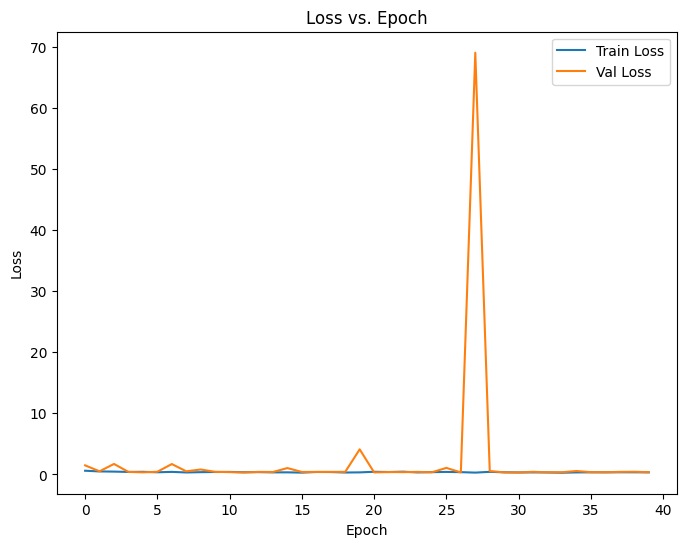

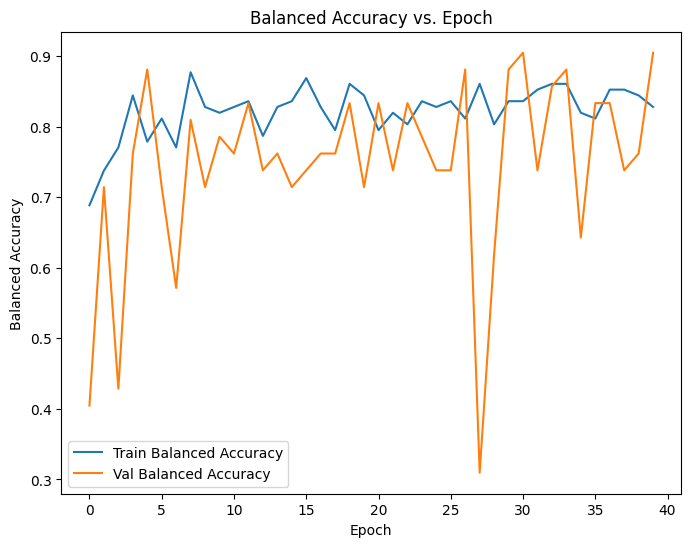

In [17]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the balanced accuracies
plt.figure(figsize=(8, 6))
plt.plot(train_balanced_accs, label='Train Balanced Accuracy')
plt.plot(val_balanced_accs, label='Val Balanced Accuracy')
plt.title('Balanced Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.show()

In [19]:
model_save_path = "model_res34_30.pth"
optimizer_save_path = "optimizer_res34_30.pth"

torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

In [14]:
# Load the model and optimizer states
model_save_path = "/kaggle/working/best_model.pth"

# Initialize the model and optimizer
model = MILModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Load the model and optimizer states
model.load_state_dict(torch.load(model_save_path))
optimizer.load_state_dict(torch.load(optimizer_save_path))

# Set the model to evaluation mode
model.eval()


MILModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [15]:
# Save the model and optimizer states after training
model_save_path = "model_10.pth"
optimizer_save_path = "optimizer_10.pth"

torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

In [20]:
import pandas as pd

# Set the model to evaluation mode
model.eval()

# Initialize a list to store the predictions
test_predictions = []
with torch.no_grad():
    # Iterate through the test_loader and collect the model's predictions
    for images, gender, count, age, _ in tqdm(test_loader, desc="Testing"):
        if images is not None:
            # Move the tensors to the device
            images = images.to(device)
            gender = gender.to(device)
            count = count.to(device)
            age = age.to(device)

            additional_features = torch.cat((gender, count, age), dim=1)
            outputs = model(images, additional_features)

            # Store the prediction as an integer
            pred = outputs.cpu().detach().numpy().squeeze()
            test_predictions.append(int(pred > 0.5))
        else:
            # Add placeholder predictions for None values
            test_predictions.extend([None] * gender.shape[0])

    # Filter out None values from the predictions
    test_predictions = [pred for pred in test_predictions if pred is not None]

    # Create a dictionary with the required format for the submission DataFrame
    sub_dict = {"Id": df_test.ID.values, "Predicted": test_predictions}

    # Convert the dictionary to a DataFrame and save it as a CSV file
    df_sub = pd.DataFrame.from_dict(sub_dict)
    df_sub.to_csv('submission.csv', index=False)


Testing: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
